In [12]:
# !git clone https://github.com/sathishkumar67/PODFCSSV.git
# !mv PODFCSSV/* /kaggle/working/

In [11]:
# import os
# import shutil

# current_path = os.getcwd()

# for item in os.listdir(current_path):
#     item_path = os.path.join(current_path, item)

#     if os.path.isfile(item_path) or os.path.islink(item_path):
#         os.remove(item_path)
#     elif os.path.isdir(item_path):
#         shutil.rmtree(item_path)

In [1]:
import torch
import torchvision
import numpy as np
import json
import os
from torchvision import transforms

def setup_cifar100_continual_federated(
    root='./data', 
    num_clients=2,      # CHANGED: Set to 2 Clients
    num_tasks=2,        # CHANGED: Set to 2 Tasks (100 classes / 2 tasks = 50 classes per task)
    alpha=0.5, 
    seed=42
):
    """
    Downloads CIFAR-100 and creates a JSON file mapping:
    Client ID -> Task ID -> List of Image Indices
    """
    print(f"Initializing Data Split: {num_clients} Clients, {num_tasks} Tasks (50 classes/task), Alpha={alpha}")
    
    # 1. Fix Seeds for Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # 2. Download CIFAR-100
    # Ensure data directory exists
    os.makedirs(root, exist_ok=True)
    
    transform = transforms.ToTensor()
    train_dataset = torchvision.datasets.CIFAR100(root=root, train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR100(root=root, train=False, download=True, transform=transform)
    
    targets = np.array(train_dataset.targets)
    classes = np.arange(100)
    
    # 3. Define Tasks (Class Incremental)
    # With num_tasks=2, this creates:
    # Task 0: Classes 0-49
    # Task 1: Classes 50-99
    classes_per_task = 100 // num_tasks
    task_splits = {t: classes[t*classes_per_task : (t+1)*classes_per_task] for t in range(num_tasks)}
    
    # Structure to save: client_data[client_id][task_id] = [indices]
    client_data = {cid: {tid: [] for tid in range(num_tasks)} for cid in range(num_clients)}
    test_data = {tid: [] for tid in range(num_tasks)}

    # 4. Perform Dirichlet Split per Task
    for task_id, task_classes in task_splits.items():
        print(f"Processing Task {task_id} (Classes {task_classes[0]}-{task_classes[-1]})...")
        
        # Save Test Data for this task (Global test set for evaluation)
        test_indices = [i for i, t in enumerate(test_dataset.targets) if t in task_classes]
        test_data[task_id] = test_indices

        # Split Training Data
        for c in task_classes:
            # Get all indices for this specific class
            idx_k = np.where(targets == c)[0]
            np.random.shuffle(idx_k)
            
            # Generate Dirichlet distribution for this class across clients
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            
            # Normalize proportions to strictly sum to 1 (handling floating point issues)
            proportions = proportions / proportions.sum()
            
            # Calculate split points based on proportions
            # Logic: Cumulative sum of proportions * total items -> cast to int for indices
            split_points = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
            
            # Split the indices
            idx_batch = np.split(idx_k, split_points)
            
            # Assign to clients
            for client_id in range(num_clients):
                client_data[client_id][task_id].extend(idx_batch[client_id].tolist())

    # 5. Save Metadata
    save_path = os.path.join(root, 'federated_splits.json')
    meta_data = {
        'client_data': client_data,
        'test_data': test_data,
        'task_config': {t: task_splits[t].tolist() for t in task_splits}
    }
    
    with open(save_path, 'w') as f:
        json.dump(meta_data, f)
        
    print(f"✅ Data preparation complete. Splits saved to {save_path}")
    
    # Validation Print
    print("\n--- Split Statistics ---")
    for cid in range(num_clients):
        print(f"Client {cid}:")
        for tid in range(num_tasks):
            count = len(client_data[cid][tid])
            print(f"  Task {tid}: {count} samples (Classes {task_splits[tid][0]}-{task_splits[tid][-1]})")

if __name__ == "__main__":
    setup_cifar100_continual_federated()

Initializing Data Split: 2 Clients, 2 Tasks (50 classes/task), Alpha=0.5


100%|██████████| 169M/169M [00:04<00:00, 41.2MB/s] 


Processing Task 0 (Classes 0-49)...
Processing Task 1 (Classes 50-99)...
✅ Data preparation complete. Splits saved to ./data/federated_splits.json

--- Split Statistics ---
Client 0:
  Task 0: 14378 samples (Classes 0-49)
  Task 1: 13103 samples (Classes 50-99)
Client 1:
  Task 0: 10622 samples (Classes 0-49)
  Task 1: 11897 samples (Classes 50-99)


In [9]:
import torch
import json
import os
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FederatedCIFAR100(Dataset):
    """
    Reads the federated_splits.json and loads specific indices for a client/task.
    """
    def __init__(self, root, split_file, client_id, task_id, train=True, transform=None):
        self.root = root
        self.transform = transform
        
        # Load the base CIFAR-100 dataset to access data by index
        # We set download=True to ensure it exists, but we won't use its internal split directly
        self.base_dataset = torchvision.datasets.CIFAR100(
            root=root, train=train, download=True
        )
        
        # Load split configuration
        with open(split_file, 'r') as f:
            splits = json.load(f)
            
        # Get indices for this specific client and task
        # JSON keys are always strings, so we convert IDs to string
        if train:
            self.indices = splits['client_data'][str(client_id)][str(task_id)]
        else:
            # For testing, we use the global test set for this task
            self.indices = splits['test_data'][str(task_id)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Map logical index to actual CIFAR-100 dataset index
        real_idx = self.indices[idx]
        
        img, label = self.base_dataset[real_idx]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

def get_dataloader(root, split_file, client_id, task_id, batch_size=32, train=True):
    # Standard augmentation for SSL (SimCLR/MAE style) could go here
    # For now, we use simple resizing to 224x224 for ViT compatibility
    transform = transforms.Compose([
        transforms.Resize(224), # ViT usually expects 224x224
        transforms.ToTensor()
    ])
    
    dataset = FederatedCIFAR100(root, split_file, client_id, task_id, train, transform)
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [40]:
import torch
import torch.nn as nn
import timm
import numpy as np

class MAE_ViT(nn.Module):
    def __init__(self, model_name='vit_small_patch16_224', mask_ratio=0.75):
        super().__init__()
        self.mask_ratio = mask_ratio
        
        # 1. Load Pretrained Encoder (ViT)
        # We remove the classifier head (num_classes=0) because we only want features
        self.encoder = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        # Extract specs from encoder
        self.embed_dim = self.encoder.embed_dim
        self.patch_size = self.encoder.patch_embed.patch_size[0]
        self.num_patches = self.encoder.patch_embed.num_patches
        
        # 2. Lightweight Decoder
        # A small Transformer to reconstruct the image from features
        decoder_dim = 128
        self.decoder_embed = nn.Linear(self.embed_dim, decoder_dim)
        
        # Learnable mask token (replaces missing patches)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        
        # Positional embeddings for decoder
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches + 1, decoder_dim), requires_grad=False
        )
        
        # Tiny transformer blocks for decoder (fewer layers than encoder for efficiency)
        self.decoder_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=4, dim_feedforward=512, batch_first=True)
            for _ in range(4)
        ])
        
        self.decoder_norm = nn.LayerNorm(decoder_dim)
        
        # 3. Prediction Head
        # Projects back to pixel space: (Patch_Size * Patch_Size * 3 colors)
        pixels_per_patch = self.patch_size * self.patch_size * 3
        self.decoder_pred = nn.Linear(decoder_dim, pixels_per_patch)
        
        self.initialize_weights()

    def initialize_weights(self):
        # Sine-cosine positional embeddings logic could go here
        # For MVP, we initialize mask token and linear layers
        torch.nn.init.normal_(self.mask_token, std=.02)
        torch.nn.init.xavier_uniform_(self.decoder_pred.weight)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by shuffling keys
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # Batch, Length, Dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # Noise in [0, 1]
        
        # Sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
        # Generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # Unshuffle to get the binary mask in the original order
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x):
        # 1. Patch Embed
        x = self.encoder.patch_embed(x)
        
        # 2. Add Positional Embeddings (Standard ViT logic)
        # We discard the CLS token pos embed for masking simplicity in this MVP
        cls_pos_embed = self.encoder.pos_embed[:, 0, :]
        patch_pos_embed = self.encoder.pos_embed[:, 1:, :]
        x = x + patch_pos_embed
        
        # 3. Masking
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)
        
        # 4. Append CLS token
        cls_token = self.encoder.cls_token + cls_pos_embed
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # 5. Apply Transformer Blocks
        x = self.encoder.blocks(x)
        x = self.encoder.norm(x)
        
        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # 1. Embed to decoder dimension
        x = self.decoder_embed(x)

        # 2. Append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token back

        # 3. Add decoder pos embed
        # Interpolate if needed, but for fixed size we just slice
        x = x + self.decoder_pos_embed[:, :x.shape[1], :]

        # 4. Apply Transformer Decoder
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # 5. Predict pixels
        x = self.decoder_pred(x)

        # Remove CLS token
        x = x[:, 1:, :]
        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        
        # MSE Loss
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        # Only compute loss on masked patches (MIM principle)
        loss = (loss * mask).sum() / mask.sum() 
        return loss

    def patchify(self, imgs):
        """
        img: (N, 3, H, W) -> (N, L, patch_size**2 *3)
        """
        p = self.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def forward(self, imgs):
        latent, mask, ids_restore = self.forward_encoder(imgs)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask
    
    def unpatchify(self, x):
        """
        Reconstructs images from patches.
        x: (N, L, patch_size**2 * 3) -> (N, 3, H, W)
        """
        p = self.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        # Reshape to (N, h, w, p, p, 3)
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        
        # Permute to (N, 3, h, p, w, p) to line up channels and spatial dims
        x = torch.einsum('nhwpqc->nchpwq', x)
        
        # Final reshape to image (N, 3, H, W)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

In [42]:
# 1. Test Data Loader
print("Testing Data Loader...")
loader = get_dataloader(
    root='./data', 
    split_file='./data/federated_splits.json', 
    client_id=0, 
    task_id=0, 
    batch_size=4
)
images, labels = next(iter(loader))
print(f"Batch Shape: {images.shape} (Expect [4, 3, 224, 224])")

# 2. Test Model
print("\nTesting MAE Model...")
model = MAE_ViT(model_name='vit_small_patch16_224')
loss, pred, mask = model(images)
print(f"Loss: {loss.item()}")
print(f"Prediction Shape: {pred.shape}")
print("✅ Phase 1 Infrastructure Ready!")

Testing Data Loader...
Batch Shape: torch.Size([4, 3, 224, 224]) (Expect [4, 3, 224, 224])

Testing MAE Model...
Loss: 0.4757227897644043
Prediction Shape: torch.Size([4, 196, 768])
✅ Phase 1 Infrastructure Ready!


In [48]:
op = model.unpatchify(pred) * torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1) + torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)

In [49]:
op.shape

torch.Size([4, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09756088..1.0875459].


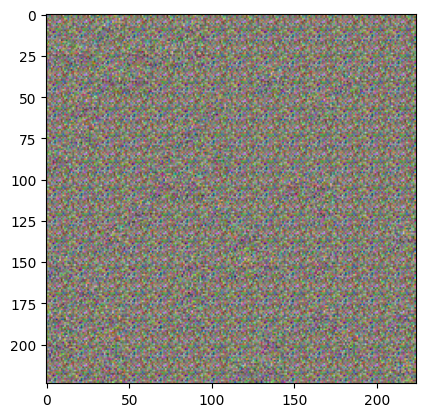

In [50]:
plt.imshow(op[0].permute(1, 2, 0).detach().cpu().numpy())

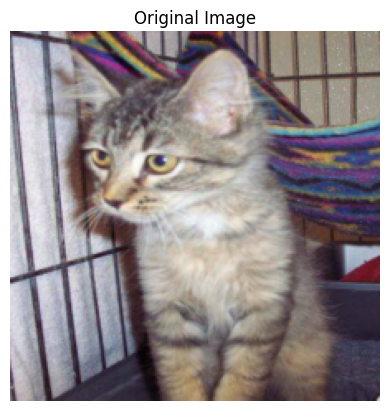

ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# -------------------------
# Configuration
# -------------------------
IMAGE_PATH = "/kaggle/input/wild-animal-detection-and-alerting-system/dataset/train_set/domestic/domestic (1).jpg"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224

# -------------------------
# Image preprocessing
# -------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load image
img = Image.open(IMAGE_PATH).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(DEVICE)

# -------------------------
# Show original image
# -------------------------
def denormalize(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(x.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(x.device)
    return x * std + mean

plt.imshow(denormalize(img_tensor)[0].permute(1,2,0).cpu())
plt.title("Original Image")
plt.axis("off")
plt.show()

# -------------------------
# Load pretrained MAE model
# -------------------------
model = timm.create_model(
    "vit_small_patch16_224",
    pretrained=True
).to(DEVICE)

model.eval()

# -------------------------
# Forward pass (reconstruction)
# -------------------------



In [54]:
model(img_tensor).shape

torch.Size([1, 1000])

In [55]:
with torch.no_grad():
    pred = model(img_tensor)

# -------------------------
# Reconstruct image
# -------------------------
# pred shape: [B, N, patch_size*patch_size*3]
# Unpatchify
reconstructed = model.unpatchify(pred)

# -------------------------
# Show reconstructed image
# -------------------------
plt.imshow(denormalize(reconstructed)[0].permute(1,2,0).cpu())
plt.title("MAE Reconstructed Image")
plt.axis("off")
plt.show()

AttributeError: 'VisionTransformer' object has no attribute 'unpatchify'

🎨 Generating Visualization...
✅ Saved to mae_visualization.png


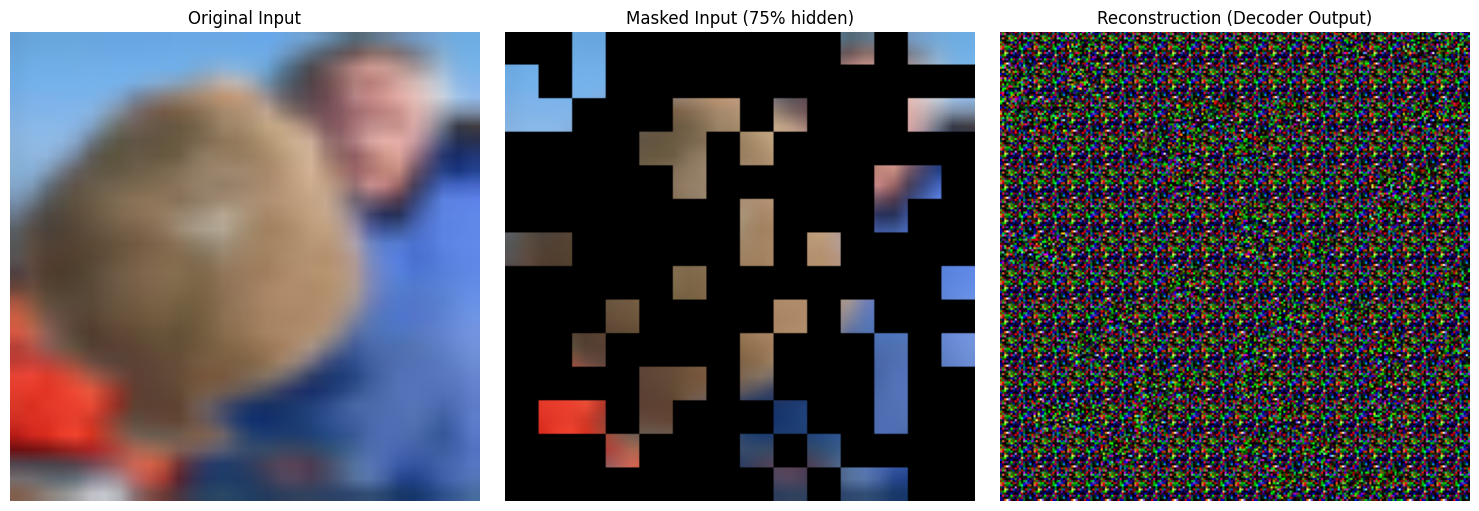

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Helper to Denormalize Images for Plotting ---
def show_image(tensor_img, title=""):
    """
    Converts a normalized tensor (C, H, W) back to a viewable image (H, W, C).
    """
    
    # Reverse Normalization: img * std + mean
    img = tensor_img.cpu().clone() 
    
    # Clip values to [0, 1] to avoid matplotlib warnings
    img = torch.clamp(img, 0, 1)
    
    # Convert to numpy and transpose to (H, W, C)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

def visualize_reconstruction():
    print("🎨 Generating Visualization...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 1. Setup Model & Load Weights
    # If you have a trained checkpoint, ensure it points there. 
    # If not, this visualizes random initialization (which will look like noise).
    model = MAE_ViT(model_name='vit_small_patch16_224')
    model.to(device)
    model.eval()

    # 2. Get One Image
    loader = get_dataloader(
        root='./data', 
        split_file='./data/federated_splits.json', 
        client_id=0, 
        task_id=0, 
        batch_size=1
    )
    img, _ = next(iter(loader))
    img = img.to(device)

    # 3. Forward Pass
    with torch.no_grad():
        loss, pred, mask = model(img)
        
        # A. Original Reconstructed Image (from patches)
        recon_img = model.unpatchify(pred) # (1, 3, 224, 224)

        # B. Visualize the Mask
        # The mask is shape (N, L) where 1=remove, 0=keep.
        # We need to project this mask back to pixel space to see what was hidden.
        # Repeat mask values to match patch pixels
        mask_tokens = mask.unsqueeze(-1).repeat(1, 1, model.patch_size**2 * 3)
        mask_visual = model.unpatchify(mask_tokens)  # (1, 3, 224, 224)
        
        # Create the "Masked View" (Original image with gray patches where masked)
        # 1 means removed, so we multiply image by (1 - mask)
        im_masked = img * (1 - mask_visual)

    # 4. Plotting
    plt.figure(figsize=(15, 5))

    # Plot Original
    plt.subplot(1, 3, 1)
    show_image(img[0], "Original Input")

    # Plot What the Model Saw (Masked)
    plt.subplot(1, 3, 2)
    show_image(im_masked[0], "Masked Input (75% hidden)")

    # Plot What the Model Predicted
    plt.subplot(1, 3, 3)
    show_image(recon_img[0], "Reconstruction (Decoder Output)")

    plt.tight_layout()
    plt.savefig('mae_visualization.png')
    print("✅ Saved to mae_visualization.png")
    plt.show()

if __name__ == "__main__":
    visualize_reconstruction()

🎨 Generating Visualization for /kaggle/input/wild-animal-detection-and-alerting-system/dataset/train_set/domestic/domestic (1).jpg...
✅ Visualization saved to mae_single_vis.png


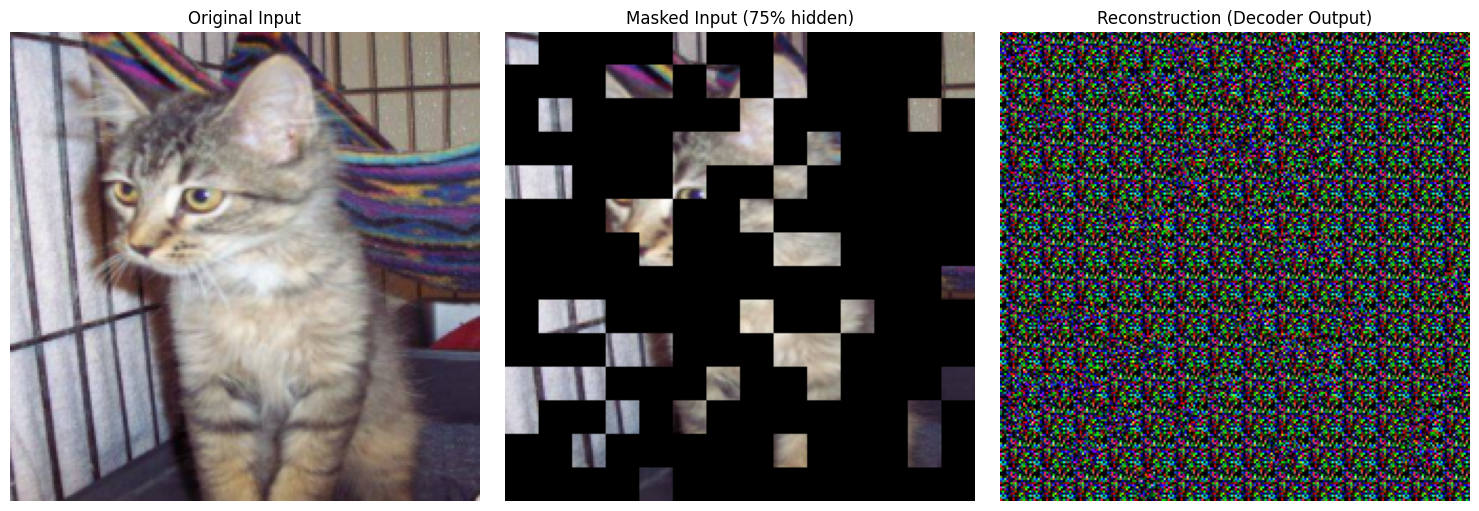

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

# --- Helper to Denormalize Images for Plotting ---
def show_image(tensor_img, title=""):
    """
    Converts a normalized tensor (C, H, W) back to a viewable image (H, W, C).
    """
    # CIFAR-100 Mean and Std (Must match what we use in Transform)
    
    # Reverse Normalization: img * std + mean
    img = tensor_img.cpu().clone() 
    
    # Clip values to [0, 1] to avoid matplotlib warnings
    img = torch.clamp(img, 0, 1)
    
    # Convert to numpy and transpose to (H, W, C)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

def visualize_reconstruction(image_path):
    print(f"🎨 Generating Visualization for {image_path}...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 1. Setup Model & Load Weights
    # Ensure architecture matches training
    model = MAE_ViT(model_name='vit_small_patch16_224')
    model.to(device)
    model.eval()

    # 2. Load and Preprocess Image
    # We must Resize to 224 and Normalize to match training distribution
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    try:
        img_pil = Image.open(image_path).convert('RGB')
        img = transform(img_pil).unsqueeze(0) # Add batch dimension: (1, 3, 224, 224)
        img = img.to(device)
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return

    # 3. Forward Pass
    with torch.no_grad():
        loss, pred, mask = model(img)
        
        # A. Original Reconstructed Image (from patches)
        recon_img = model.unpatchify(pred) # (1, 3, 224, 224)

        # B. Visualize the Mask
        # The mask is shape (N, L) where 1=remove, 0=keep.
        # Repeat mask values to match patch pixels
        mask_tokens = mask.unsqueeze(-1).repeat(1, 1, model.patch_size**2 * 3)
        mask_visual = model.unpatchify(mask_tokens)  # (1, 3, 224, 224)
        
        # Create the "Masked View" (Original image with gray patches where masked)
        # 1 means removed, so we multiply image by (1 - mask)
        im_masked = img * (1 - mask_visual)

    # 4. Plotting
    plt.figure(figsize=(15, 5))

    # Plot Original
    plt.subplot(1, 3, 1)
    show_image(img[0], "Original Input")

    # Plot What the Model Saw (Masked)
    plt.subplot(1, 3, 2)
    show_image(im_masked[0], "Masked Input (75% hidden)")

    # Plot What the Model Predicted
    plt.subplot(1, 3, 3)
    show_image(recon_img[0], "Reconstruction (Decoder Output)")

    plt.tight_layout()
    save_name = 'mae_single_vis.png'
    plt.savefig(save_name)
    print(f"✅ Visualization saved to {save_name}")
    plt.show()

if __name__ == "__main__":
    # Replace this with the path to your image
    path_to_image = "/kaggle/input/wild-animal-detection-and-alerting-system/dataset/train_set/domestic/domestic (1).jpg" 
    
    # Simple check to create a dummy image if one doesn't exist
    import os
    if not os.path.exists(path_to_image):
        print(f"Creating dummy {path_to_image} for testing...")
        Image.fromarray(np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)).save(path_to_image)

    visualize_reconstruction(path_to_image)

In [5]:
import torch
import torch.optim as optim
from tqdm import tqdm

def train_client_ssl(
    model, 
    dataloader, 
    epochs=1, 
    lr=1e-3, 
    device='cuda'
):
    """
    Simulates local training on a client node.
    Returns: State dictionary of the trained model.
    """
    model.to(device)
    model.train()
    
    # Simple AdamW optimizer (standard for Transformers)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    
    epoch_loss = 0.0
    
    for epoch in range(epochs):
        batch_loss = 0.0
        count = 0
        
        # Iterating over local data
        for images, _ in dataloader: # Label is ignored in SSL
            images = images.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass (MAE logic inside model)
            loss, _, _ = model(images)
            
            loss.backward()
            optimizer.step()
            
            batch_loss += loss.item()
            count += 1
            
        epoch_loss += batch_loss / count

    # Return model weights (cpu) to free GPU memory
    return model.state_dict(), epoch_loss

In [6]:
import torch
import copy

def fed_avg(global_model, client_weights_list):
    """
    Aggregates client weights using Federated Averaging.
    
    global_model: The base model architecture
    client_weights_list: List of state_dicts from clients
    """
    # Create a deep copy to avoid modifying the original during calculation
    new_weights = copy.deepcopy(global_model.state_dict())
    
    num_clients = len(client_weights_list)
    
    # Iterate over every parameter in the model (e.g., layer1.weight, layer2.bias)
    for key in new_weights.keys():
        # Initialize tensor to zero
        avg_tensor = torch.zeros_like(new_weights[key], dtype=torch.float32)
        
        # Sum up weights from all clients
        for client_w in client_weights_list:
            avg_tensor += client_w[key]
            
        # Divide by number of clients
        new_weights[key] = avg_tensor / num_clients
        
    return new_weights

In [7]:
import torch
import copy
import os
import matplotlib.pyplot as plt

def run_federated_ssl_simulation():
    # --- Configurations ---
    NUM_CLIENTS = 2          # From your data setup
    NUM_ROUNDS = 5           # Small number for testing
    LOCAL_EPOCHS = 2         # Epochs per round
    BATCH_SIZE = 16
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"🚀 Starting Federated SSL Pretraining on {DEVICE}...")
    
    # 1. Initialize Global Model
    global_model = MAE_ViT(model_name='vit_small_patch16_224')
    global_model.to(DEVICE)
    
    # 2. Federated Training Loop
    loss_history = []
    
    for round_idx in range(NUM_ROUNDS):
        print(f"\n--- Round {round_idx+1}/{NUM_ROUNDS} ---")
        
        local_weights = []
        round_losses = []
        
        # Simulate Clients (Sequential Execution)
        for client_id in range(NUM_CLIENTS):
            # Load Client Data (Task 0 for pretraining)
            train_loader = get_dataloader(
                root='./data',
                split_file='./data/federated_splits.json',
                client_id=client_id,
                task_id=0,
                batch_size=BATCH_SIZE,
                train=True
            )
            
            # Copy global model to client
            # (In simulation, we just load state_dict)
            client_model = MAE_ViT(model_name='vit_small_patch16_224')
            client_model.load_state_dict(global_model.state_dict())
            
            # Train Locally
            print(f"Client {client_id} training...", end='\r')
            w_local, loss = train_client_ssl(
                client_model, train_loader, epochs=LOCAL_EPOCHS, device=DEVICE
            )
            
            local_weights.append(w_local)
            round_losses.append(loss)
        
        # Server Aggregation
        print(f"\nAggregating updates...")
        new_global_weights = fed_avg(global_model, local_weights)
        global_model.load_state_dict(new_global_weights)
        
        avg_round_loss = sum(round_losses) / len(round_losses)
        loss_history.append(avg_round_loss)
        print(f"Global Loss: {avg_round_loss:.4f}")

    # 3. Save Pretrained Model
    os.makedirs('checkpoints', exist_ok=True)
    save_path = 'checkpoints/ssl_pretrained_task0.pth'
    torch.save(global_model.state_dict(), save_path)
    print(f"\n✅ Pretraining Complete! Model saved to {save_path}")

    # 4. Plot Loss Curve
    plt.figure()
    plt.plot(range(1, NUM_ROUNDS+1), loss_history, marker='o')
    plt.title('Federated SSL Pretraining Loss')
    plt.xlabel('Communication Round')
    plt.ylabel('Reconstruction Loss')
    plt.grid(True)
    plt.savefig('ssl_loss_curve.png')
    print("Graph saved to ssl_loss_curve.png")

if __name__ == "__main__":
    run_federated_ssl_simulation()

🚀 Starting Federated SSL Pretraining on cuda...

--- Round 1/5 ---
Client 1 training...
Aggregating updates...
Global Loss: 1.2886

--- Round 2/5 ---
Client 1 training...
Aggregating updates...
Global Loss: 1.2449

--- Round 3/5 ---
Client 1 training...
Aggregating updates...
Global Loss: 1.2384

--- Round 4/5 ---


KeyboardInterrupt: 